# LSTM on real DNA sequences

# Leggi qui
Nella parte prima di START HERE ho commentato le linee che non servono più perché ho già generato i file necessari, che puoi trovare nella mia cartella /ubuntu (non dovrebbero esserci problemi di permessi). 

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import subprocess
import numpy as np
from Bio import SeqIO

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
intr_coords = pd.read_csv('Akey_intr_coords.bed', header = None, sep = "\t")
intr_coords.head()

,0,1,2
0,chr1,2903159,2915884
1,chr1,2932446,2972497
2,chr1,2960608,2996556
3,chr1,2960608,2999518
4,chr1,2960608,3001253


In [4]:
intr_lengths = intr_coords.iloc[:, 2]-intr_coords.iloc[:, 1]

In [5]:
print(stats.describe(intr_lengths))

DescribeResult(nobs=83601, minmax=(10002, 1194940), mean=92137.5803877944, variance=6139175379.516866, skewness=2.7095069302166377, kurtosis=11.38558261567325)


In [6]:
#!zcat hg19.fa.gz | bgzip -c > hg19.fa.bgz

In [7]:
"""a = 0
with open('hg19_intr_regions.fa', 'a') as fp:
    for i in range(intr_coords.shape[0]):
        coord = str(str(intr_coords.iloc[i, 0]) + ':' 
                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')"""

"a = 0\nwith open('hg19_intr_regions.fa', 'a') as fp:\n    for i in range(intr_coords.shape[0]):\n        coord = str(str(intr_coords.iloc[i, 0]) + ':' \n                    + str(intr_coords.iloc[i, 1]) + '-' + str(intr_coords.iloc[i, 2]))\n        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')"

In [8]:
"""chr_sizes = pd.read_csv("hg19.fa.bgz.fai", header = None, sep = "\t")
chr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)
chr_sizes.head()"""

'chr_sizes = pd.read_csv("hg19.fa.bgz.fai", header = None, sep = "\t")\nchr_sizes = chr_sizes.drop([2, 3, 4], axis = 1)\nchr_sizes.head()'

In [9]:
"""chr_list = []
start_list = []
end_list = []
intr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])
a = 0
for i in range(intr_coords.shape[0]):
    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]
    overlap = True
    while overlap == True:
        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))
        reg_end = reg_start + intr_lengths[i]
        for j in range(chr_df.shape[0]):
            b1 = chr_df.iloc[j,1]
            b2 = chr_df.iloc[j,2]
            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or \
            (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):
                overlap = True
                break
            else:
                overlap = False
    chr_list.append(intr_coords.iloc[i,0])
    start_list.append(reg_start)
    end_list.append(reg_end)
    a = a + 1
    if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal introgressed haplotypes')
depl_coords = pd.DataFrame({'0': chr_list, '1': start_list, '2': end_list})
depl_coords.to_csv("Akey_depl_coords.bed", index = False, header = False, sep = "\t")
depl_coords.head()"""

'chr_list = []\nstart_list = []\nend_list = []\nintr_lengths = list(intr_coords.iloc[:, 2] - intr_coords.iloc[:, 1])\na = 0\nfor i in range(intr_coords.shape[0]):\n    chr_df = intr_coords[intr_coords[0].isin([intr_coords.iloc[i,0]])]\n    overlap = True\n    while overlap == True:\n        reg_start = np.random.randint(1, int(chr_sizes[chr_sizes[0] == intr_coords.iloc[i,0]].iloc[:,1]))\n        reg_end = reg_start + intr_lengths[i]\n        for j in range(chr_df.shape[0]):\n            b1 = chr_df.iloc[j,1]\n            b2 = chr_df.iloc[j,2]\n            if (reg_start > b1 and reg_start < b2) or (reg_end > b1 and reg_end < b2) or             (b1 > reg_start and b1 < reg_end) or (b2 > reg_start and b2 < reg_end):\n                overlap = True\n                break\n            else:\n                overlap = False\n    chr_list.append(intr_coords.iloc[i,0])\n    start_list.append(reg_start)\n    end_list.append(reg_end)\n    a = a + 1\n    if a%10000 == 0:\n            print(\'Fini

In [10]:
#depl_coords = pd.read_csv("Akey_depl_coords.bed", sep = "\t")

In [11]:
#!bedtools intersect -a Akey_intr_coords.bed -b Akey_depl_coords.bed | wc -l

In [12]:
"""a = 0
with open('hg19_depl_regions.fa', 'a') as fp:
    for i in range(depl_coords.shape[0]):
        coord = str(str(depl_coords.iloc[i, 0]) + ':' 
                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))
        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')"""

"a = 0\nwith open('hg19_depl_regions.fa', 'a') as fp:\n    for i in range(depl_coords.shape[0]):\n        coord = str(str(depl_coords.iloc[i, 0]) + ':' \n                    + str(depl_coords.iloc[i, 1]) + '-' + str(depl_coords.iloc[i, 2]))\n        subprocess.run(['samtools', 'faidx', 'hg19.fa.bgz', str(coord)], stdout = fp)\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' Neanderthal ancestry depleted regions')"

In [13]:
#!grep -c N hg19_intr_regions.fa

In [14]:
#!grep -c N hg19_depl_regions.fa

In [15]:
"""intr_file = 'hg19_intr_regions.fa'
depl_file = 'hg19_depl_regions.fa'
a = 0
i = 0
with open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:
    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
        upper_intr = intr.seq.upper()
        upper_depl = depl.seq.upper()
        a = a + 1
        if a%10000 == 0:
            print('Finished ' + str(a) + ' entries')
        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):
            intr.seq = upper_intr
            SeqIO.write(intr, intr_out, 'fasta')
            depl.seq = upper_depl
            SeqIO.write(depl, depl_out, 'fasta')
            i = i + 1
        else:
            continue
print('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')"""

"intr_file = 'hg19_intr_regions.fa'\ndepl_file = 'hg19_depl_regions.fa'\na = 0\ni = 0\nwith open('hg19_intr_clean.fa', 'a') as intr_out, open('hg19_depl_clean.fa', 'a') as depl_out:\n    for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):\n        upper_intr = intr.seq.upper()\n        upper_depl = depl.seq.upper()\n        a = a + 1\n        if a%10000 == 0:\n            print('Finished ' + str(a) + ' entries')\n        if 'N' not in str(upper_intr) and 'N' not in str(upper_depl):\n            intr.seq = upper_intr\n            SeqIO.write(intr, intr_out, 'fasta')\n            depl.seq = upper_depl\n            SeqIO.write(depl, depl_out, 'fasta')\n            i = i + 1\n        else:\n            continue\nprint('We have processed ' + str(a) + ' entries and written ' + str(i) + ' entries to two fasta-files')"

In [16]:
#!grep -c N hg19_intr_regions.fa

In [17]:
#!grep -c N hg19_depl_regions.fa

# START HERE

Qui il codice commentato è perché volevo fare un po' di prove, quindi può essere cambiato a piacimento

Attenzione perché la rete così com'è ci mette tanto ad allenarsi.

In [18]:
intr_file = 'hg19_intr_clean.fa'
depl_file = 'hg19_depl_clean.fa'

"""a = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    cut = 1000
    if len(str(intr.seq)) < cut or len(str(depl.seq)) < cut:
        continue
    s_intr = str(intr.seq)[0:cut]
    s_depl = str(depl.seq)[0:cut]
    if s_intr.count('A')>0 and s_intr.count('C')>0 and s_intr.count('G')>0 and s_intr.count('T')>0 and \
    s_depl.count('A')>0 and s_depl.count('C')>0 and s_depl.count('G')>0 and s_depl.count('T')>0:
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
    a = a + 1
    if a%10000 == 0:
        print('Finished ' + str(a) + ' entries')"""

e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    #cutoff = 200
    #my_intr_seq = str(intr.seq)[0:cutoff]
    #my_depl_seq = str(depl.seq)[0:cutoff]
    #intr_seqs.append(my_intr_seq)
    #depl_seqs.append(my_depl_seq)
    
    step = 200; jump = 1; a = 0; b = step; n_jumps = 5
    for j in range(n_jumps):
        s_intr = str(intr.seq)[a:b]
        s_depl = str(depl.seq)[a:b]
        intr_seqs.append(s_intr)
        depl_seqs.append(s_depl)
        a = a + jump
        b = a + step
    
    e = e + 1
    if e%10000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]



def getKmers2(sequence, size):
    snt= [sequence[x*size:x*(size+1)].upper() for x in range(0,len(sequence)//(size+1))]
    out=np.zeros((4,len(snt)))
    mydict={"A":0,"C":1,"G":2,"T":3}
    for s in range(len(snt)):
        counts = Counter(snt[s])
        for l in set(snt[s]):
            out[mydict[l],s]=counts[l]
    display(pd.DataFrame(out))
    return(out)
    



#intr_texts = [getKmers(i, kmer) for i in intr_seqs]
#depl_texts = [getKmers(i, kmer) for i in intr_seqs]
print(np.array(depl_seqs).shape)

Finished 10000 entries
Finished 20000 entries
Finished 30000 entries
Finished 40000 entries
Finished 50000 entries
Finished 60000 entries
Finished 70000 entries
(366820,)


## ROBA SULLA CORRELAZIONE / FREQUENZA

E' lungo, se non interessa passare direttamente al RIparti da qui

In [19]:
def split(seqs):
    a=np.array([[c for c in seq.upper()]for seq in seqs])
    print(a.shape)
    return(a)
humans=split(depl_seqs)
neanderthals=split(intr_seqs)

(366820, 200)
(366820, 200)


In [20]:
#Must be perfomed on the pure chains, not divided in words.
new_dict={'A':0, "C":1 , "G":2, "T":3}
print("START")
r=[i for i in [5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]]

couples_h=np.zeros((4,4,len(r)))
freqs_h=np.zeros(4)
couples_n=np.zeros((4,4, len(r)))
freqs_n=np.zeros(4)

for sentence in humans:
    for nuc in sentence:
        freqs_h[new_dict[nuc]]+=1
freqs_h=freqs_h/(humans.shape[0]*humans.shape[1])
print("Freqs H")
print(freqs_h)
fh_h=list(freqs_h)

print()

freqs_h=[[b for b in freqs_h]for a in freqs_h]
freqs_h=np.array(freqs_h).reshape((4,4))
print(freqs_h[:,0])

for sentence in neanderthals:
    for nuc in sentence:
        freqs_n[new_dict[nuc]]+=1
freqs_n=freqs_n/(neanderthals.shape[0]*neanderthals.shape[1])

print("Freqs_ N ")
print(freqs_n)
fn_n=list(freqs_n)

freqs_n=[[b for b in freqs_n]for a in freqs_n]
freqs_n=np.array(freqs_n).reshape(4,4)

print("Done P(x_i)")

for k in range(len(r)):
    for sentence in humans:
         for idx in range(len(sentence)-r[k]):
                couples_h[new_dict[sentence[idx]],new_dict[sentence[idx+r[k]]], k ]+=1            
    #couples_h[:,:,k]=couples_h[:,:,k]/(humans.shape[0]*(humans.shape[1]-r[k]))
    couples_h[:,:,k]=couples_h[:,:,k]/np.sum(couples_h[:,:,k],axis=1).reshape((4,1))
    print(k, " um")
                
for k in range(len(r)):
    for sentence in neanderthals:
         for idx in range(len(sentence)-r[k]):
                couples_n[new_dict[sentence[idx]],new_dict[sentence[idx+r[k]]], k ]+=1
    #couples_n[:,:,k]=couples_n[:,:,k]/(neanderthals.shape[0]*(neanderthals.shape[1]-r[k]))
    couples_n[:,:,k]=couples_n[:,:,k]/np.sum(couples_n[:,:,k],axis=1).reshape((4,1))
    print(k , " nean")           
print("Done P(x_i|x_j)")
#for i in range(len(r)):
#    print("Check")
#    print(couples_n[:,:,i])

#compute correlations
    #sum i sum j couples[i,j]-

Cr_h=np.zeros(len(r))
Cr_n=np.zeros(len(r))
for k in range(len(r)):
 
    print(np.sum(couples_h[:,:,k]-freqs_h))
    Cr_h[k]=np.sum((couples_h[:,:,k]-freqs_h)**2)
    Cr_n[k]=np.sum((couples_n[:,:,k]-freqs_n)**2)

print(freqs_h.shape)

START
Freqs H
[0.29393624 0.20640634 0.20671496 0.29294246]

[0.29393624 0.29393624 0.29393624 0.29393624]


KeyboardInterrupt: 

In [ ]:
# Dont see any correlation..
import matplotlib.pyplot as plt
#plt.xscale=('linear')

corrs_hn=np.array([r,Cr_h,Cr_n])
corrs_hn = corrs_hn.reshape((3,len(r))).T
corrs_hn[:,-2:]=np.sqrt(corrs_hn[:,-2:])
display(pd.DataFrame(corrs_hn))
#np.savetxt(corrs_hnm)
#np.save_txt(rCr)
plt.title("Temporal Correlation HG19")
plt.scatter(corrs_hn[:,0],corrs_hn[:,1], label="Depleted", alpha =0.7)
plt.scatter(corrs_hn[:,0],corrs_hn[:,2], label="Introgressed", alpha =0.7)
plt.plot(corrs_hn[:,0],corrs_hn[:,1])
plt.plot(corrs_hn[:,0],corrs_hn[:,2])
#plt.ylim(0,+0.025)
plt.ylabel("Q(r)")
plt.xlabel("r")
plt.legend()
plt.savefig("Temporal_corr_real_V31")
#plt.xscale=('log')
plt.show()




In [ ]:
print(freqs_h)
plt.title("Nucleotides Frequency HG19")
plt.bar(range(4),fh_h,0.2, label = "Depleted", alpha =0.7)
plt.bar(np.array(range(4))+0.25,fn_n,0.2, label= "Introgressed", color ="C1", alpha =0.7)
plt.xticks([0.1+i for i in range(4)], ['A','C','G','T'])
plt.ylim(0,0.3)
plt.legend()
plt.savefig("Nucleotides_freal_V3")
plt.show()

plt.bar(range(4),abs(np.array(fn_n)-np.array(fh_h)), label= "|freqh-freqn|")
plt.ylim(0,+0.0006)
plt.legend()
plt.show()

## RIPARTI DA QUI

In [21]:
kmer = 10
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]


In [22]:
"""sequences = intr_seqs + depl_seqs
len(sequences)"""

merge_texts = intr_texts + depl_texts
len(merge_texts)
#print(merge_texts[:10])

733640

In [23]:
"""labels = list(np.ones(len(intr_seqs))) + list(np.zeros(len(depl_seqs)))
len(labels)"""

labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))

733640


In [24]:
"""e = 0
intr_seqs = []
depl_seqs = []
for intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):
    
    cutoff = 200
    my_intr_seq = str(intr.seq)[0:cutoff]
    my_depl_seq = str(depl.seq)[0:cutoff]
    
    intr_seqs.append(my_intr_seq)
    depl_seqs.append(my_depl_seq)
    
    e = e + 1
    if e%20000 == 0:
        print('Finished ' + str(e) + ' entries')
        
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

kmer = 10
intr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]
depl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]"""

"e = 0\nintr_seqs = []\ndepl_seqs = []\nfor intr, depl in zip(SeqIO.parse(intr_file, 'fasta'), SeqIO.parse(depl_file, 'fasta')):\n    \n    cutoff = 200\n    my_intr_seq = str(intr.seq)[0:cutoff]\n    my_depl_seq = str(depl.seq)[0:cutoff]\n    \n    intr_seqs.append(my_intr_seq)\n    depl_seqs.append(my_depl_seq)\n    \n    e = e + 1\n    if e%20000 == 0:\n        print('Finished ' + str(e) + ' entries')\n        \ndef getKmers(sequence, size):\n    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]\n\nkmer = 10\nintr_texts = [' '.join(getKmers(i, kmer)) for i in intr_seqs]\ndepl_texts = [' '.join(getKmers(i, kmer)) for i in depl_seqs]"

In [25]:
"""merge_texts = intr_texts + depl_texts
len(merge_texts)"""

'merge_texts = intr_texts + depl_texts\nlen(merge_texts)'

In [26]:
"""labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))
print(len(labels))"""

'labels = list(np.ones(len(intr_texts))) + list(np.zeros(len(depl_texts)))\nprint(len(labels))'

In [27]:
#cv = CountVectorizer()
#X = cv.fit_transform(merge_texts)

#tfidf_transformer = TfidfTransformer()
#X = tfidf_transformer.fit_transform(X)
print("1")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merge_texts)
#X = tokenizer.texts_to_matrix(merge_texts, mode = 'freq')
print("2")
encoded_docs = tokenizer.texts_to_sequences(merge_texts)
max_length = max([len(s.split()) for s in merge_texts])
X = pad_sequences(encoded_docs, maxlen = max_length, padding = 'post')
print("3")
print(X)
print('\n')
print(X.shape)

1
2
3
[[153634 568397 382160 ... 635443 506832 658088]
 [568397 382160 380712 ... 506832 658088 654350]
 [382160 380712 323461 ... 658088 654350 503434]
 ...
 [  1173    900    397 ...  64841  93299 115195]
 [   900    397    537 ...  93299 115195 135311]
 [   397    537   1117 ... 115195 135311  63747]]


(733640, 191)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size = 0.20, random_state = 42)

In [29]:
print(X_train.shape)
print(X_test.shape)

(586912, 191)
(146728, 191)


In [30]:
X_train1 = X_train[:200000]
X_test1 = X_test[:5000]
y_train1 = y_train[:200000]
y_test1 = y_test[:5000]
print(X_train.shape)
print(X_test.shape)

(586912, 191)
(146728, 191)


In [31]:
"""X_eva_test=np.array(X_test1)
reverse_word_map = pd.Series(dict(map(reversed, tokenizer.word_index.items())))
print("test3")
print(X_eva_test[0,:30])
print(reverse_word_map[X_eva_test[0,:30]])
print(tokenizer.texts_to_sequences(reverse_word_map[X_eva_test[0,:30]]))"""

'X_eva_test=np.array(X_test1)\nreverse_word_map = pd.Series(dict(map(reversed, tokenizer.word_index.items())))\nprint("test3")\nprint(X_eva_test[0,:30])\nprint(reverse_word_map[X_eva_test[0,:30]])\nprint(tokenizer.texts_to_sequences(reverse_word_map[X_eva_test[0,:30]]))'

In [32]:
max_length = max([len(s.split()) for s in merge_texts])
print(max_length)

191


In [33]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

944238


In [34]:
"""model = Sequential()
#model.add(Dense(3000, input_shape = (X.shape[1],), activation = 'sigmoid'))
model.add(Embedding(vocab_size, 32, input_length = max_length, dropout = 0.2))
#model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(LSTM(10)) #dropout = 0.2, recurrent_dropout = 0.2
#model.add(GRU(10))
model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))
#model.add(Flatten())
#model.add(Dense(10, activation = 'sigmoid'))
model.add(Dense(1, activation = 'sigmoid'))

epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')
print(model.summary())"""

'model = Sequential()\n#model.add(Dense(3000, input_shape = (X.shape[1],), activation = \'sigmoid\'))\nmodel.add(Embedding(vocab_size, 32, input_length = max_length, dropout = 0.2))\n#model.add(Conv1D(filters = 16, kernel_size = 5, padding = \'same\', activation = \'relu\'))\n#model.add(MaxPooling1D(pool_size = 2))\n#model.add(LSTM(10)) #dropout = 0.2, recurrent_dropout = 0.2\n#model.add(GRU(10))\nmodel.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))\n#model.add(Flatten())\n#model.add(Dense(10, activation = \'sigmoid\'))\nmodel.add(Dense(1, activation = \'sigmoid\'))\n\nepochs = 5\nmodel.compile(loss = \'binary_crossentropy\', optimizer = \'rmsprop\', metrics = [\'accuracy\'])\n#model.compile(loss = \'binary_crossentropy\', optimizer = \'adam\', metrics = [\'accuracy\'])\n#model.compile(loss = \'binary_crossentropy\', optimizer = \'SGD\', metrics = [\'accuracy\'])\n#model.compile(loss = \'binary_crossentropy\', optimizer = RMSprop(lr = 0.0001), metrics = [\'accuracy\'])\nche

In [35]:
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras import  Sequential
#model = Sequential()
#model.add(Embedding(vocab_size, 10)) #dropout = 0.2 #input_length = max_length
#model.add(Conv1D(filters = 16, kernel_size = 5, padding = 'same', activation = 'relu'))
#model.add(MaxPooling1D(pool_size = 2))
#model.add(LSTM(10)) #dropout = 0.2, recurrent_dropout = 0.2
#model.add(Bidirectional(LSTM(10))) #dropout = 0.2, recurrent_dropout = 0.2
#model.add(Bidirectional(SimpleRNN(10)))
#model.add(GRU(10))
#model.add(SimpleRNN(10, dropout = 0.2, recurrent_dropout = 0.2))
#model.add(Flatten())
#model.add(Dense(10, activation = 'relu'))
#model.add(Dense(1, activation = 'sigmoid'))

model = Sequential()
model.add(Embedding(vocab_size, 10))
model.add(Bidirectional(LSTM(10)))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))


epochs = 5
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = 'SGD', metrics = ['accuracy'])
#model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(lr = 0.0001), metrics = ['accuracy'])
#checkpoint = ModelCheckpoint("weights.best.hdf5", monitor = 'val_acc', verbose = 1, 
#                             save_best_only = True, mode = 'max')
model.load_weights("LSTM.weights.best.hdf5")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          9442380   
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                1680      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 9,444,281
Trainable params: 9,444,281
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
#history = model.fit(X_train1, y_train1, 
#                    epochs = 1, verbose = 1, validation_split = 0.2, batch_size = 32, shuffle = True) 
                    #callbacks = [checkpoint])

In [37]:

import itertools
import operator



## Questo trovava forse le parole comuni per neanderthal e umani

In [38]:
#print(X_train1[:5])
import itertools
import operator
from collections import Counter 


#print(reverse_word_map[X_train[1][0]])
y_train1=np.array(y_train1)
X_train_tmp_1=X_train1[y_train1==1]
X_train_tmp_0=X_train1[y_train1==0]

import pandas
from collections import Counter
#intresting words per pos: 

how_many_common_words = 50

cmnw1=np.zeros((how_many_common_words,X_train_tmp_0.shape[1]))
cmnw0=np.zeros((how_many_common_words,X_train_tmp_0.shape[1]))
for j in range(X_train_tmp_1.shape[1]):
    letter_counts0 = Counter(X_train_tmp_0[:,j]).most_common(how_many_common_words)
    letter_counts1 = Counter(X_train_tmp_1[:,j]).most_common(how_many_common_words)
    #print(max(letter_counts1.items(), key=lambda kv: kv[1])[:10])
    #cnt=np.dtype('int,int')
    letter_counts0=np.array(letter_counts0)
    letter_counts1=np.array(letter_counts1)
    #print(letter_counts0[:,0])
    cmnw1[:,j]=letter_counts1[:,0]
    cmnw0[:,j]=letter_counts0[:,0]
       
display(pd.DataFrame(cmnw1))
display(pd.DataFrame(cmnw0))



,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,123042.0,81.0,81.0,12219.0,130.0,91.0,100.0,2859.0,100.0,100.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,4.0,2.0,2.0
2,47034.0,118.0,42477.0,130.0,64853.0,28749.0,24289.0,2.0,1125.0,2.0,...,8.0,119.0,3.0,4.0,3.0,4.0,4.0,2.0,3.0,4.0
3,2243.0,94256.0,34165.0,33815.0,237.0,27335.0,2859.0,130.0,2.0,1125.0,...,3.0,9.0,121.0,3.0,4.0,3.0,3.0,3.0,4.0,77.0
4,12484.0,69.0,74.0,69.0,202.0,100.0,113.0,1125.0,69.0,181.0,...,11.0,3.0,7.0,119.0,10.0,119.0,13.0,77.0,5.0,3.0
5,94256.0,19555.0,149.0,74.0,91.0,245201.0,184844.0,6789.0,97.0,324.0,...,4.0,4.0,4.0,11.0,121.0,18.0,153.0,18.0,153.0,6.0
6,30770.0,58408.0,291.0,331.0,74.0,139348.0,105787.0,14351.0,171.0,81.0,...,38.0,39.0,11.0,192.0,192.0,13.0,121.0,119.0,23.0,5.0
7,118.0,32654.0,4291.0,202.0,34883.0,165.0,291.0,324.0,3291.0,15399.0,...,9.0,10.0,42.0,10.0,86.0,86.0,5.0,59.0,13.0,141.0
8,2302.0,2171.0,120600.0,248.0,44184.0,15851.0,92795.0,21535.0,68883.0,3291.0,...,121.0,7.0,48.0,8635.0,36.0,167.0,19970.0,14.0,121.0,119.0
9,41903.0,59792.0,77321.0,291.0,138111.0,398.0,80558.0,162782.0,140802.0,97.0,...,119.0,16.0,119.0,137.0,14.0,7.0,37.0,86.0,6.0,25.0


,0,1,2,3,4,5,6,7,8,9,...,181,182,183,184,185,186,187,188,189,190
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
2,6.0,5.0,6.0,29.0,32.0,20.0,28.0,28.0,6.0,5.0,...,3.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0,3.0,4.0
3,23.0,8.0,16.0,15.0,6.0,10.0,20.0,6.0,5.0,6.0,...,8.0,15.0,26.0,7.0,5.0,6.0,7.0,6.0,5.0,13.0
4,124.0,15.0,27.0,7.0,11.0,32.0,6.0,5.0,27.0,20.0,...,15.0,8.0,19.0,16.0,15.0,27.0,5.0,9.0,7.0,112.0
5,16.0,28.0,9.0,5.0,29.0,5.0,10.0,29.0,18.0,23.0,...,22.0,20.0,25.0,28.0,27.0,9.0,16.0,15.0,94.0,57.0
6,14.0,78.0,19.0,11.0,10.0,6.0,5.0,27.0,32.0,41.0,...,4.0,27.0,7.0,27.0,7.0,16.0,15.0,3.0,14.0,11.0
7,85.0,86.0,7.0,16.0,7.0,11.0,41.0,21.0,68.0,29.0,...,11.0,9.0,9.0,6.0,11.0,10.0,66.0,5.0,4.0,6.0
8,13.0,14.0,29.0,46.0,52.0,41.0,133.0,20.0,73.0,68.0,...,21.0,25.0,4.0,26.0,46.0,23.0,8.0,73.0,106.0,14.0
9,19.0,49.0,155.0,10.0,101.0,72.0,23.0,94.0,28.0,28.0,...,28.0,19.0,27.0,19.0,18.0,49.0,68.0,28.0,111.0,106.0


## Algoritmo lento come la morte, passa al prossimo titolo

In [39]:
"""#catch positions

import tensorflow.keras
from IPython.display import clear_output
y_test1=np.array(y_test1)
diffs=np.zeros((X_test1.shape[1]))
for i in range(X_test1.shape[1]):
    X_eva_test=np.array(X_test1)
    #print(model.evaluate(X_eva_test,np.array(y_test1) ))
    np.random.shuffle(X_eva_test[:,i])
    for j in range(-kmer+1,kmer-1):
        print(j)
        if(not(j+i<0 or j+i>=X_test1.shape[1])): 
        
            u=0
            for row in X_eva_test:
                clear_output(wait=True)
                print(u, " / ", X_test1.shape[0])
                u=u+1
                reverse_word_map = pd.series(dict(map(reversed, tokenizer.word_index.items())))
                #print(reverse_word_map[row[j+i]])
                if (j>0):
                    tmp_= join((reverse_word_map[row[i]][0:j],reverse_word_map[row[j+i]][j:]))
                    #print ("old ", reverse_word_map[row[j+i]])
                    #print( "shuf " , reverse_word_map[row[i]]) 
                    #print("piece left ", reverse_word_map[row[j+i]][0:j] ) 
                    #print("piece right " , reverse_word_map[row[j+i]][j:] )
                    #print("new ", tmp_)
                    if tmp_ in tokenizer.word_index.keys():
                        row[j+1]=(tokenizer.word_index[tmp_])
                    else :
                        tokenizer.word_index.setdefault(tmp_,max(reverse_word_map.keys())+1)

                elif (j<0):
                    tmp_= reverse_word_map[row[j+i]][0:j]+reverse_word_map[row[i]][j:]
                    #print (reverse_word_map[row[j+i]],"", reverse_word_map[row[i]])
                    #print (reverse_word_map[row[j+i]][0:j],"", reverse_word_map[row[i]][j:])
                    #print(tmp_)

                    if tmp_ in tokenizer.word_index.keys():
                        #print(tokenizer.word_index[tmp_])
                        row[j+1]=(tokenizer.word_index[tmp_])
                    else :
                        tokenizer.word_index.setdefault(tmp_,max(reverse_word_map.keys())+1)


        
        #modify kmer
        #reapply tokenizer.
    
    c=model.evaluate(X_eva_test,np.array(y_test1))[1]
    
    
    #print(X_train_tmp_1[:10,:10])
    #print(np.mean(model.evaluate(X_eva_test,np.array(y_test1))))
    
    diffs[i]=diffs[i]-(a+b+c)/3
    clear_output(wait=True)
    print("last result ", i, " " ,diffs[i] , " " ,i, "/" , X_test1.shape[1])
    print(a, "  ", b, " ", c)
    
plt.scatter(range(0,len(diffs)), diffs)"""

'#catch positions\n\nimport tensorflow.keras\nfrom IPython.display import clear_output\ny_test1=np.array(y_test1)\ndiffs=np.zeros((X_test1.shape[1]))\nfor i in range(X_test1.shape[1]):\n    X_eva_test=np.array(X_test1)\n    #print(model.evaluate(X_eva_test,np.array(y_test1) ))\n    np.random.shuffle(X_eva_test[:,i])\n    for j in range(-kmer+1,kmer-1):\n        print(j)\n        if(not(j+i<0 or j+i>=X_test1.shape[1])): \n        \n            u=0\n            for row in X_eva_test:\n                clear_output(wait=True)\n                print(u, " / ", X_test1.shape[0])\n                u=u+1\n                reverse_word_map = pd.series(dict(map(reversed, tokenizer.word_index.items())))\n                #print(reverse_word_map[row[j+i]])\n                if (j>0):\n                    tmp_= join((reverse_word_map[row[i]][0:j],reverse_word_map[row[j+i]][j:]))\n                    #print ("old ", reverse_word_map[row[j+i]])\n                    #print( "shuf " , reverse_word_map[row[i

## Questo perturba da DIo

 iteration  190  : perturbated res =  0.9944 saved value =  0.0055999755859375
Questo print e quello simile sotto sono fighi, perchè vedi che quando perturbi sulle posizioni che li riguardano sono diversi, sennò sono uguali
[174759  66253  68964 134604  68334 128556 160936 148981 431370 122895]
[174759  66253  68964 134604  68334 128556 160936 148981 431370 122895]
(5000, 191)


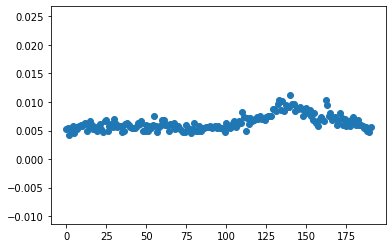

In [40]:
def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

import tensorflow.keras
from IPython.display import clear_output
prts=[10]  #lo avevo fatto anche per tante lunghezze diverse, cambia poco

for prt in prts: 
    diffs=np.zeros((200-prt+1))
    for i in range(200-prt+1): 
        print(i , "/", X_test1.shape[1])
        X_eva_test=np.array(X_test1)
        
        reverse_word_map = pd.Series(dict(map(reversed, tokenizer.word_index.items()))) #inverted tokenizer
        X_tmp0=np.array(reverse_word_map[X_eva_test.reshape(X_eva_test.shape[0]*X_eva_test.shape[1])]).reshape(
            X_eva_test.shape[0],X_eva_test.shape[1]) #coverti tutto in kmers , serviva aggiustare le shape per farlo
        #veloce

        X_tmp0=X_tmp0[:,range(0,X_tmp0.shape[1],kmer)]  #becca solo kmer che non overlap
        X_tmp0=np.array(list(np.sum(np.sum(X_tmp0,axis=1),axis=0))).reshape(X_tmp0.shape[0],200) 
        #qua hai una matrice Nx200 di nucleotidi.
        
        range_helper=[k for k in range(0,X_tmp0.shape[0])]
        np.random.shuffle(range_helper)                          #shuffle
        X_tmp0[:,i:i+prt]=X_tmp0[range_helper,i:i+prt]   #applica shuffle
        X_tmp0=[''.join(X_tmp0[j,:]) for j in range(X_tmp0.shape[0])] #recupera sequenza nucs
        X_tmp0=[' '.join(getKmers(seq,kmer)) for seq in X_tmp0] #recupera sequenza kmers
    
    
        #now you have to get back to the tokens, evaluate and you are done
        X_tmp0=tokenizer.texts_to_sequences(X_tmp0)
        X_tmp0= pad_sequences(X_tmp0, maxlen = max_length, padding = 'post')
   
   

        print(X_tmp0.shape)
        c=model.evaluate(X_tmp0,np.array(y_test1))[1]
        diffs[i]=(1-c)                            #qua butto fuori le 
        # 1 - accuratezze , più è grande più la posizione è importante
    
    
         
        clear_output(wait=True)
        
        print(" iteration ", i, " : perturbated res = ", c , "saved value = " , diffs[i])
        print("Questo print e quello simile sotto sono fighi, perchè vedi che quando perturbi sulle posizioni che li riguardano sono diversi, sennò sono uguali")
        print(X_eva_test[0][10:20]) #DEBUG
        print(X_tmp0[0][10:20])
        print(X_tmp0.shape)

    np.savetxt("important_locs_nnn"+str(prt)+"_.txt", diffs)    
    plt.scatter(range(0,len(diffs)), diffs) 

## Perturbazione nucleotidi tipo 0 (Depleted) va sistemato fai affidamento a quell osopra

Questi due sotto non vanno a vedere l'accuracy ma a vedere di quanto cambiava la predizione alla fine funzionava ma cambiava poco dall' altro, ho lasciato perdere

In [ ]:
"""def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

import tensorflow.keras
from IPython.display import clear_output
prts=[10]

for prt in prts: 
    diffs=np.zeros((200-prt+1))
    for i in range(200-prt+1):
        
        X_eva_test=np.array(X_test1)
        print(X_eva_test[0][30:40])
        reverse_word_map = pd.Series(dict(map(reversed, tokenizer.word_index.items())))
        X_tmp0=np.array(reverse_word_map[X_eva_test.reshape(X_eva_test.shape[0]*X_eva_test.shape[1])]).reshape(
            X_eva_test.shape[0],X_eva_test.shape[1])
        #print((X_tmp0[0,30:40]))
        X_tmp0=X_tmp0[:,range(0,X_tmp0.shape[1],kmer)]
        X_tmp0=np.array(list(np.sum(np.sum(X_tmp0,axis=1),axis=0))).reshape(X_tmp0.shape[0],200)
        #print((X_tmp0[0]))
        range_helper=[k for k in range(0,X_tmp0.shape[0])]
        np.random.shuffle(range_helper)
        X_tmp0[:,i:i+prt]=X_tmp0[range_helper,i:i+prt]
        X_tmp0=[''.join(X_tmp0[j,:]) for j in range(X_tmp0.shape[0])]
        X_tmp0=[' '.join(getKmers(seq,kmer)) for seq in X_tmp0]
        #X_tmp0=[getKmers(seq,kmer) for seq in X_tmp0]
        #print(X_tmp0[0][30:40])
        #now you have to get back to the tokens, evaluate and you are done
        X_tmp0=tokenizer.texts_to_sequences(X_tmp0)
        X_tmp0= pad_sequences(X_tmp0, maxlen = max_length, padding = 'post')
        X_tmp0=X_tmp0[np.array(y_test1)==0.0,:]
        print(X_tmp0.shape)
        y_test_0=[0]*X_tmp0.shape[0]
        print(X_tmp0.shape)
        print("not p EVALUATION = ", diffs[i])
        #c=model.evaluate(X_tmp0,np.array( y_test_0))[1]
        #diffs[i]=(c)
        c=model.predict(X_tmp0)
        diffs[i]=np.mean(c)
        clear_output(wait=True)
        print(X_tmp0[0][30:40])
        print("perturbated res = ", c )
        print(i , "/", X_test1.shape[1])
    np.savetxt("important_nnnlocs_"+str(prt)+"_zeros_preds_.txt", diffs)    
    plt.scatter(range(0,len(diffs)), diffs)  
    plt.show()"""

 ## QUI Perturbazione Nucleotidi tipo 1 (Introgressed) non serve affidamento a quello buono

In [ ]:
"""

def getKmers(sequence, size):
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

import tensorflow.keras
from IPython.display import clear_output
prts=[10]

for prt in prts: 
    diffs=np.zeros((200-prt+1))
    for i in range(200-prt+1):
        
        X_eva_test=np.array(X_test1)
        print(X_eva_test[0][30:40])
        reverse_word_map = pd.Series(dict(map(reversed, tokenizer.word_index.items())))
        X_tmp0=np.array(reverse_word_map[X_eva_test.reshape(X_eva_test.shape[0]*X_eva_test.shape[1])]).reshape(
            X_eva_test.shape[0],X_eva_test.shape[1])
        #print((X_tmp0[0,30:40]))
        X_tmp0=X_tmp0[:,range(0,X_tmp0.shape[1],kmer)]
        X_tmp0=np.array(list(np.sum(np.sum(X_tmp0,axis=1),axis=0))).reshape(X_tmp0.shape[0],200)
        #print((X_tmp0[0]))
        range_helper=[k for k in range(0,X_tmp0.shape[0])]
        np.random.shuffle(range_helper)
        X_tmp0[:,i:i+prt]=X_tmp0[range_helper,i:i+prt]
        X_tmp0=[''.join(X_tmp0[j,:]) for j in range(X_tmp0.shape[0])]
        X_tmp0=[' '.join(getKmers(seq,kmer)) for seq in X_tmp0]
        #X_tmp0=[getKmers(seq,kmer) for seq in X_tmp0]
        #print(X_tmp0[0][30:40])
        #now you have to get back to the tokens, evaluate and you are done
        X_tmp0=tokenizer.texts_to_sequences(X_tmp0)
        X_tmp0= pad_sequences(X_tmp0, maxlen = max_length, padding = 'post')
        X_tmp0=X_tmp0[np.array(y_test1)==1.0,:]
        print(X_tmp0.shape)
        y_test_0=[1]*X_tmp0.shape[0]
        print(X_tmp0.shape)
        print("not p EVALUATION = ", diffs[i])
        #c=model.evaluate(X_tmp0,np.array( y_test_0))[1]
        c=model.predict(X_tmp0)
        diffs[i]=np.mean(c)
        clear_output(wait=True)
        print(X_tmp0[0][30:40])
        print("perturbated res = ", c )
        print(i , "/", X_test1.shape[1])
    np.savetxt("important_nnnlocs_"+str(prt)+"_.txt", diffs)    
#plt.scatter(range(0,len(diffs)), diffs)   """

### Una volta salvata la mappa di importanza apposto, da qua in poi non serve nulla è solo roba disordinata
### nemmeno sò se funziona

In [ ]:
"""np.savetxt("important_locs_"+str(prt)+"_zerosa_.txt", diffs)
ops = np.loadtxt("important_locs"+".txt")"""




In [ ]:
"""diffs[i]=model.evaluate(X_eva_test,np.array(y_test1) )[1]
    print(X_eva_test[(y_test1)==1,:].shape)
    X_eva_test[np.array(y_test1)==1,i]=np.random.choice(cmnw0[:,i],(X_eva_test[(y_test1)==1,:].shape[0]))
    X_eva_test[np.array(y_test1)==0,i]=np.random.choice(cmnw1[:,i],(X_eva_test[(y_test1)==0,:].shape[0]))
    a=model.evaluate(X_eva_test,np.array(y_test1))[1]
    X_eva_test[np.array(y_test1)==1,i]=np.random.choice(cmnw0[:,i],(X_eva_test[(y_test1)==1,:].shape[0]))
    X_eva_test[np.array(y_test1)==0,i]=np.random.choice(cmnw1[:,i],(X_eva_test[(y_test1)==0,:].shape[0]))
    b=model.evaluate(X_eva_test,np.array(y_test1))[1]
    X_eva_test[np.array(y_test1)==1,i]=np.random.choice(cmnw0[:,i],(X_eva_test[(y_test1)==1,:].shape[0]))
    X_eva_test[np.array(y_test1)==0,i]=np.random.choice(cmnw1[:,i],(X_eva_test[(y_test1)==0,:].shape[0]))"""

In [ ]:
"""ops = np.convolve(ops,[1,2,3,4,5,6,7,8,9,10,9,8,7,6,5,4,3,2,1])
print(len(ops))
plt.scatter(range(0,len(ops)), ops/sum(abs(ops)))
plt.ylim(0,0.03)

positions= np.where(abs(diffs)/sum(abs(diffs))>0.01)"""

In [ ]:
"""print (positions)
hwords=50
type1w=cmnw1[:hwords,positions[0]]
type0w=cmnw0[:hwords,positions[0]]
print((type0w.shape))
print(len(positions[0]))
obsmat=np.zeros((len(positions[0]),len(positions[0]),hwords,hwords))
X_eva_test0=np.array(X_test1[np.array(y_test1)==0])
X_eva_test1=np.array(X_test1[np.array(y_test1)==1])
X_eva_test1=X_eva_test1[:,positions[0]]
X_eva_test0=X_eva_test0[:,positions[0]]
for sentence in X_eva_test0:
    #print(sentence)
    #print()
    for i in range(X_eva_test0.shape[1]): 
        if sentence[i] not in type0w: break
        else:
            for j in range(X_eva_test0.shape[1]): 
                if sentence[j] not in type0w: break
                else:
                    a=np.where(sentence[i] == type0w[:,i])
                    b=np.where(sentence[j] == type0w[:,j])
                    #print(a)
                    obsmat[i,j,a,b]+=1;
                
display(np.where(obsmat!=0))

                
"""

In [ ]:
"""#well now i know what to substitute..
#let's catch the most intresting positions
for i in range(X_train_tmp_1.shape[0]):
    tmparr=np.ones((X_train_tmp_1.shape[1]*how_many_common_words,X_train_tmp_1.shape[1]))
    tmparr=tmparr*X_train_tmp_1[i]
    print(tmparr)
    for j in range(tmparr.shape[0]):
        #print(j%how_many_common_words," ", j//how_many_common_words)
        tmparr[j,j//how_many_common_words]=cmnw0[j%how_many_common_words,j//how_many_common_words]
    resedo=model.predict(cmnw0)
    #print(np.mean(resedo), resedo[0])



"""
